## Regression Model
---

Suppose we have data $(y_1,x_1),\dots,(y_n,x_n)$. Let $u_i$ denote the error term for the $i$-th pair $(y_i,x_i)$, $(i=1,\dots,n)$. We assume each $u_i$ independently follows the normal distribution with mean 0 and variance $\sigma^2$. Then the regression model is given by

$$
 y_i = \alpha + \beta x_i + u_i,\quad u_i \sim \mathrm{Normal}(0,\sigma^2).
$$

where $\alpha$, $\beta$ and $\sigma^2$ are unknown parameters.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from IPython.display import display
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

PyMC (https://www.pymc.io/welcome.html) is a Python package for Bayesian data analysis. Please read instructions at https://github.com/nakatsuma/probability_and_statistics before you install PyMC. It is a preferred practice to set up an independent environment for each project because it makes management of versions and dependencies much easier.


In [2]:
import pymc as pm

As a numerical illustration, we generate artificial data from a simple regression model.

$$
 y_i = 1 + 2 x_i + u_i,\quad u_i \sim \mathrm{Normal}(0, (0.7)^2).
$$

In this example, we generate $x_i$ from a uniform distribution over $[-\sqrt{3},\sqrt{3}]$ whose mean and variance are 0 and 1 respectively.

In [3]:
n = 50
rng = np.random.default_rng(seed=99)
u = st.norm.rvs(scale=0.7, size=n, random_state=rng)
x = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n, random_state=rng)
y = 1.0 + 2.0 * x + u
X = np.stack((np.ones(n), x), axis=1)

The following cell plots the generated data.

In [4]:
x_range = np.array([-1.1*np.sqrt(3.0), 1.1*np.sqrt(3.0)])
y_range = np.array([1.0 + 2.0*x_range[0], 1.0 + 2.0*x_range[1]])
p = figure(width=400, height=300, toolbar_location=None, title='Simple Regression')
p.line(x_range, y_range, line_color='navy', line_width=2, legend_label='Regression line')
p.cross(x, y, color='firebrick', size=8, legend_label='Observations')
p.xaxis.axis_label = 'x'
p.yaxis.axis_label = 'y'
p.legend.location = 'top_left'
p.legend.click_policy = 'hide'
p.legend.border_line_color = p.xgrid.grid_line_color = p.ygrid.grid_line_color = p.outline_line_color = None
show(p)

The prior distribution of $\alpha$, $\beta$ and $\sigma^2$ are

\begin{align*}
 \begin{bmatrix} \alpha \\ \beta \end{bmatrix}
 &\sim \mathrm{Normal}\left(
 \begin{bmatrix} \mu_{\alpha} \\ \mu_{\beta} \end{bmatrix},
 \begin{bmatrix} \omega_{\alpha}^2 & 0 \\ 0 & \omega_{\beta}^2 \end{bmatrix},
 \right), \\
 \sigma^2 &\sim \mathrm{Inv.Gamma}\left(\frac{\nu_0}{2},\frac{\lambda_0}{2}\right).
\end{align*}


In [5]:
mu_a = 0.0
mu_b = 0.0
omega_a = 10.0
omega_b = 10.0
nu0 = 0.02
lam0 = 0.02

In PyMC, the model is defined by `with` statement. A general syntax of `with` is as follows.

```Python
with model_object:
    model specifications
```

`model_object` is either given by a PyMC function `Model` as

```Python
 model_object = pm.Model()
```

or defined in the `with` statement as

```Python
with pm.Model() as model_object:
```

The following line specifies that `sigma2` follows the inverse gamma distribution, Inv.Gamma(0.5\*nu0, 0.5\*lam0).

```Python
sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0)
```

`'sigma2'` is the name of the variable.

These two lines specify that `a` and `b` follow the normal distributions, Normal(mu_a,omega_a\*\*2) and Normal(mu_b,omega_b\*\*2), respectively.

```Python
    a = pm.Normal('a', mu=mu_a, sigma=omega_a)
    b = pm.Normal('b', mu=mu_b, sigma=omega_b)
```

In the next line, we define the regression line `y_hat`.

```Python
    y_hat = a + b * x
```

Finally we specify the likelihood of the regression model.

```Python
    likelihood = pm.Normal('y', mu=y_hat, sigma=pm.math.sqrt(sigma2), observed=y)
```

The option `observed` specifies the data vector.


In [6]:
regresssion_normal_invgamma = pm.Model()
with regresssion_normal_invgamma:
    sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0)
    a = pm.Normal('a', mu=mu_a, sigma=omega_a)
    b = pm.Normal('b', mu=mu_b, sigma=omega_b)
    y_hat = a + b * x
    likelihood = pm.Normal('y', mu=y_hat, sigma=pm.math.sqrt(sigma2), observed=y)

A PyMC function `sample` generates a Monte Carlo sample of parameters from the posterior distribution. 

+ `draws` - number of draws per chain you generate from the posterior distribution
+ `chains` - number of chains you generate (`chains` \* `draws` = sample size)
+ `tune` - number of initial draws for tuning parameters in the sampler
+ `target_accept` - acceptance rate (higher is better, but it will take more computing time)
+ `random_seed` - seed of the pseudo-random number generator
+ `nuts_sampler` - sampling backend (`'numpyro'` is used in this code)
+ `progressbar` - the progressbar is not displayed if `False`


In [7]:
n_draws = 5000
n_chains = 4
n_tune = 1000
with regresssion_normal_invgamma:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=rng, nuts_sampler='numpyro', progressbar=False)

Compiling...
Compilation time = 0:00:02.831613
Sampling...
Sampling time = 0:00:01.143133
Transforming variables...
Transformation time = 0:00:00.051367


ArviZ (https://python.arviz.org/en/latest/index.html) is a Python package for exploratory analysis of Bayesian models. 

In [8]:
import arviz as az

A AeviZ function `summary` computes the posterior statistics with the Monte Carlo sample.

In [9]:
display(az.summary(trace, hdi_prob=0.95))

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.175,0.086,1.005,1.341,0.001,0.000,18316.0,14259.0,1.0
b,1.854,0.093,1.669,2.037,0.001,0.001,17034.0,12984.0,1.0
sigma2,0.373,0.079,0.232,0.530,0.001,0.000,16975.0,13115.0,1.0


#### Effective sample size

\begin{equation*}
 \hat T_{e} = \frac{T}{1+2\sum_{s=1}^S\hat\rho_s},
\end{equation*}

where	

\begin{equation*}
 \hat\rho_s = \frac{\hat\gamma_s}{\hat\gamma_0},\quad 
 \hat\gamma_s = \frac1{T}\sum_{t=s+1}^T(\theta_t-\bar\theta)(\theta_{t-s}-\bar\theta),\quad 
 \bar\theta = \frac1{T}\sum_{t=1}^T\theta_t.
\end{equation*}

#### Gelman-Rubin convergence diagnostic $\hat R$

\begin{equation*}
 \hat R =\sqrt{\frac{\hat V}{\hat W}},\quad 
 \hat V = \frac{n-1}{n}\hat W + \frac1{n}\hat B,
\end{equation*}
\begin{align*}
 \hat B &= \frac{n}{m-1}\sum_{j=1}^m(\bar\theta_{\cdot j}-\bar\theta)^2,\quad \bar\theta_{\cdot j} = \frac1{n}\sum_{i=1}^n\theta_{ij}, \\
 \hat W &= \frac1{m}\sum_{j=1}^m s_j^2,\quad s_j^2 = \frac1{n-1}\sum_{i=1}^n(\theta_{ij}-\bar\theta_{\cdot j})^2.
\end{align*}


An ArviZ function `plot_trace` plots the Monte Carlo sample and draws the marginal posterior p.d.f. obtained with the kernel denisty estimation method.

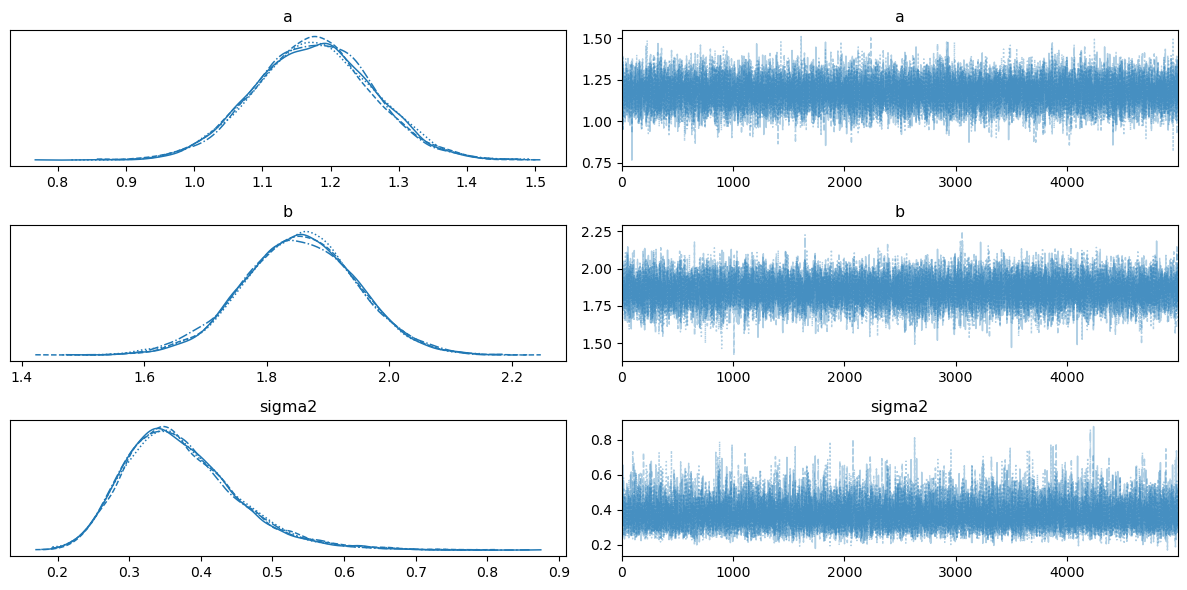

In [10]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

An ArviZ function `plot_posterior` plots the marginal posterior p.d.f with the point estimate and the HPDI.

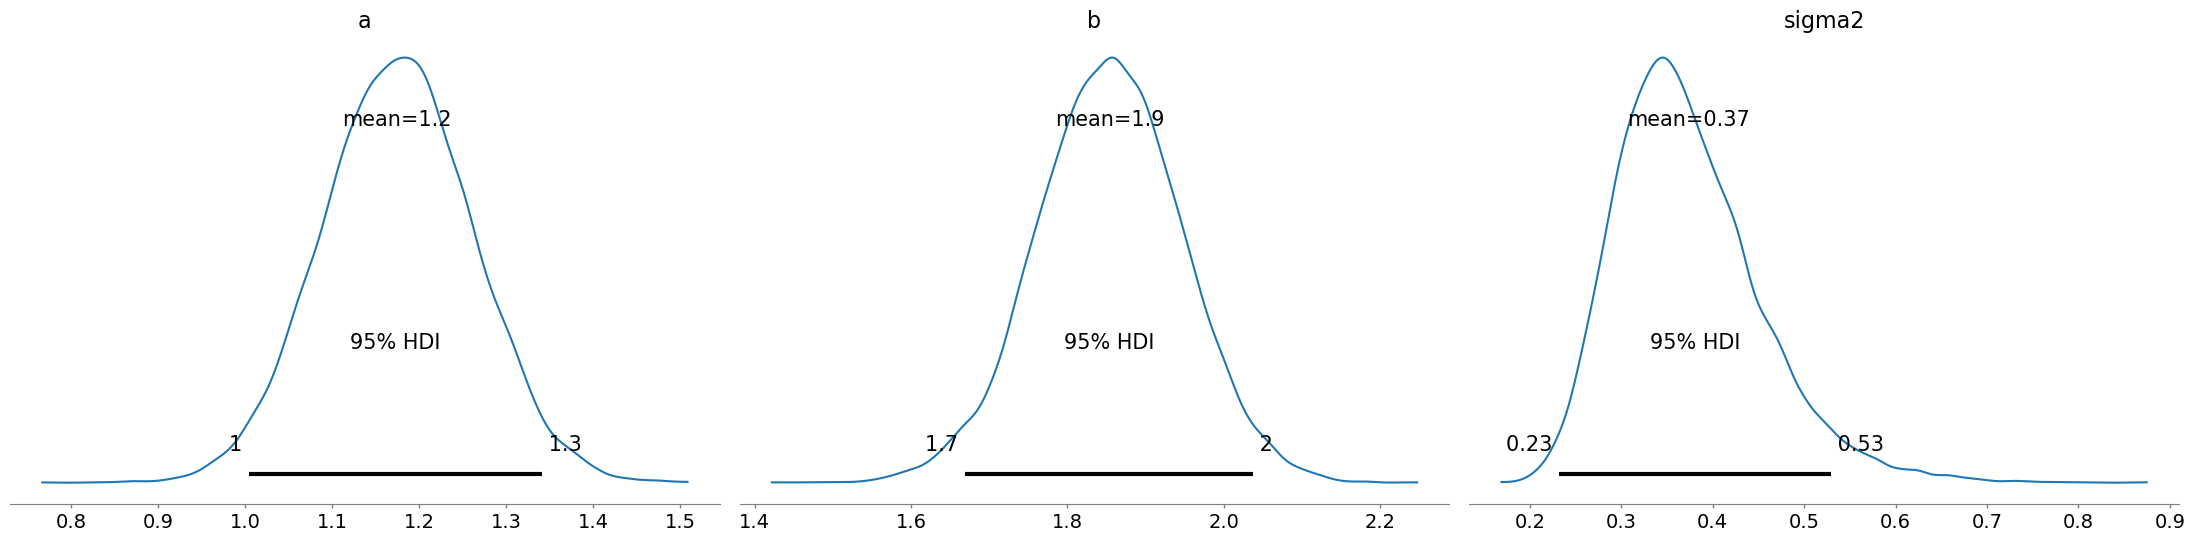

In [11]:
az.plot_posterior(trace, kind='kde', point_estimate='mean', hdi_prob=0.95)
plt.tight_layout()
plt.show()